<a href="https://colab.research.google.com/github/dablro12/AI_study/blob/main/HW4_model_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [ ]:
#data transform 
train_transforms = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels = 1),
        transforms.Resize((64, 64)),
        transforms.ToTensor()
    ]
)
#prefix setting 
train_batch_size = 800
valid_batch_size = 200
path_train = 'rsna2018/train/'
path_valid = 'rsna2018/valid/'

#data load
trainset = torchvision.datasets.ImageFolder(root = path_train, transform = train_transforms)
validset = torchvision.datasets.ImageFolder(root = path_valid, transform = train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = train_batch_size, shuffle = True)
validloader = torch.utils.data.DataLoader(validset, batch_size = valid_batch_size, shuffle = False)

#result : confusion matrix class definition
#class confusion_mtx(self, result):
#  def __init__(self):

tgtnames = trainset.classes
tgtnames

['normal', 'opacity']

torch.Size([800, 1, 64, 64])
torch.Size([800])


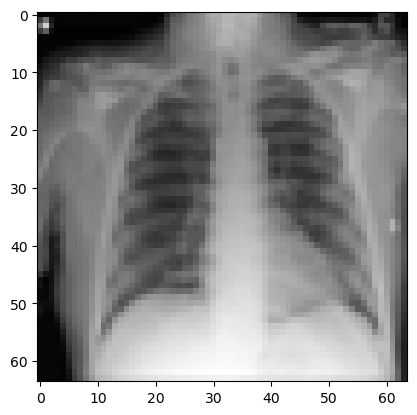

torch.Size([200, 1, 64, 64])
torch.Size([200])


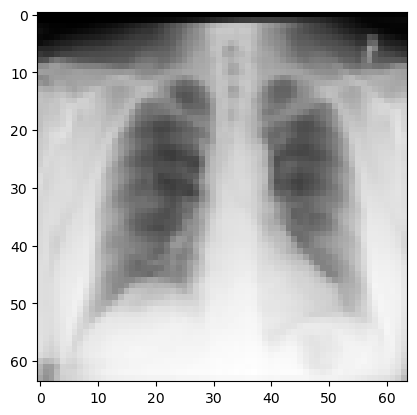

In [ ]:
#data check
for X, y in trainloader:
  print(X.shape) #-> [x, 1, 64, 64] = [batch size, channel, w, h]
  print(y.shape)
  f = X[0][0].numpy()
  plt.figure()
  plt.imshow(f, cmap = 'gray')
  plt.show()
  break

for X, y in validloader:
  print(X.shape)
  print(y.shape)
  f = X[0][0].numpy()
  plt.figure()
  plt.imshow(f, cmap = 'gray')
  plt.show()
  break

# 3-1. 나만의 CNN model을 pytorch의 nn.Sequential을 이용하여 정의하여 CNN model을 학습
* 학습이 완료된 model을 통해 valid폴더의 데이터(normal 100, opacity 100)에 대한 예측을 진행하고 결과를 confusion matrix로 요약합니다.

In [ ]:
#custom modeling
mycnn = torch.nn.Sequential(
    # [batch, 1, 64, 64] -> [batch, 16, 64, 64] 
    nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 5),
    nn.ReLU(),
    # [batch, 16, 64, 64] -> [batch, 32, 64, 64]
    nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5),
    nn.ReLU(),
    # [batch, 32, 64, 64] -> [batch, 32, 32, 32]
    nn.AvgPool2d(kernel_size = 2, stride = 2), #2*2 kernel이용하므로 이미지 사이즈가 반으로 줄어듬 
    # [batch, 32, 32, 32] -> [batch, 64, 32, 32]
    nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5),
    nn.ReLU(),
    # [batch, 32, 32, 32] -> [batch, 64, 16, 16]
    nn.AvgPool2d(kernel_size = 2, stride = 2),
    nn.Flatten(), # 전체를 하나의 곱으로 나타내줌 다음 func의 input channel 주의 
    nn.ReLU(),
    nn.Linear(9216, 2, bias=True),

)
#GPU연결.. 안되네 왜지?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#CPU OR GPU 연결
mycnn = mycnn.to(device)

#Hyper parameter setting 
learning_rate =  .05
num_epochs = 200
loss = torch.nn.CrossEntropyLoss() #CELoss
alg = torch.optim.SGD(mycnn.parameters(), lr = learning_rate) #SGD


print(device)
print(mycnn)
torch.cuda.is_available()

cpu
Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (3): ReLU()
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (6): ReLU()
  (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): ReLU()
  (10): Linear(in_features=9216, out_features=2, bias=True)
)


False

In [ ]:
#learning 
loss_train = np.array([])
accs_train = np.array([])
accs_valid = np.array([])

for epoch in range(num_epochs):
    i=0
    l_epoch = 0
    correct = 0
    mycnn.train()
    for X,y in trainloader:
        i=i+1
        X,y = X.to(device),y.to(device)
        y_hat = mycnn(X)
        correct += (y_hat.argmax(dim=1)==y).sum()
        l=loss(y_hat,y)
        l_epoch+=l
        alg.zero_grad()
        l.backward()
        alg.step()

    loss_train = np.append(loss_train,l_epoch.cpu().detach().numpy()/i)
    accs_train = np.append(accs_train,correct.cpu()/len(trainset))

    correct = 0
    mycnn.eval()
    for X,y in validloader:
        X,y = X.to(device),y.to(device)
        y_hat = mycnn(X)
        correct += (y_hat.argmax(dim=1)==y).sum()

    accs_valid = np.append(accs_valid,correct.cpu()/len(validset))

    plt.figure(2,dpi=80)
    plt.subplot(121)
    plt.plot(loss_train,label='train loss')
    plt.legend(loc='upper right')
    plt.subplot(122)
    plt.plot(accs_train,label='train accuracy')
    plt.plot(accs_valid,label='valid accuracy')
    plt.legend(loc='upper left')
    plt.title('epoch: %d '%(epoch))
    plt.savefig('loss_curve.png')
#   plt.show()
    plt.close(2)

    if epoch%5 == 0:
        print('epoch: %d '%(epoch))
        print('train loss: ',loss_train[-1])
        print('train accuracy: ',accs_train[-1])
        print('valid accuracy: ',accs_valid[-1])


epoch: 0 
train loss:  0.6924996972084045
train accuracy:  0.5
valid accuracy:  0.5049999952316284
epoch: 5 
train loss:  0.6900471448898315
train accuracy:  0.7412499785423279
valid accuracy:  0.7549999952316284
epoch: 10 
train loss:  0.6865373849868774
train accuracy:  0.7300000190734863
valid accuracy:  0.7400000095367432
epoch: 15 
train loss:  0.6808690428733826
train accuracy:  0.7462499737739563
valid accuracy:  0.7549999952316284
epoch: 20 
train loss:  0.6703624725341797
train accuracy:  0.7512500286102295
valid accuracy:  0.7549999952316284
epoch: 25 
train loss:  0.6473225951194763
train accuracy:  0.7749999761581421
valid accuracy:  0.7850000262260437
epoch: 30 
train loss:  0.589917004108429
train accuracy:  0.7862499952316284
valid accuracy:  0.7850000262260437
epoch: 35 
train loss:  3.7957069873809814
train accuracy:  0.5
valid accuracy:  0.5
epoch: 40 
train loss:  0.6921142339706421
train accuracy:  0.5
valid accuracy:  0.5
epoch: 45 
train loss:  0.6897891163825989


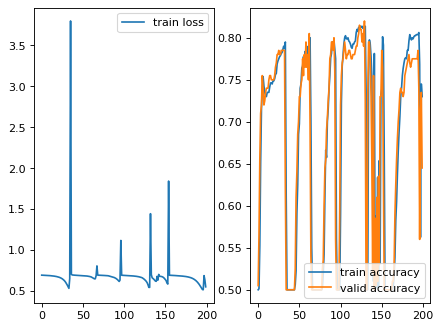

normal
[[ 0.6218316 -0.5332693]]
prediction of mycnn: normal


In [ ]:
from PIL import Image
#result check
plt.figure(2,dpi=80)
plt.subplot(121)
plt.plot(loss_train,label='train loss')
plt.legend(loc='upper right')
plt.subplot(122)
plt.plot(accs_train,label='train accuracy')
plt.plot(accs_valid,label='valid accuracy')
plt.legend(loc='lower right')
plt.show()

N = 42
I = Image.open(validset.imgs[N][0])
X = train_transforms(I)
y = validset.targets[N]

print(tgtnames[y])
y_hat = mycnn(X.unsqueeze(1).to(device))
print(y_hat.cpu().detach().numpy())
y_hat = y_hat.argmax(dim=1)
print(f'prediction of mycnn: {tgtnames[y_hat.cpu().numpy()[0]]}')

              precision    recall  f1-score   support

      normal       0.59      0.94      0.73       100
     opacity       0.85      0.35      0.50       100

    accuracy                           0.65       200
   macro avg       0.72      0.65      0.61       200
weighted avg       0.72      0.65      0.61       200

200명 중 맞춘 확률 : 64.5%


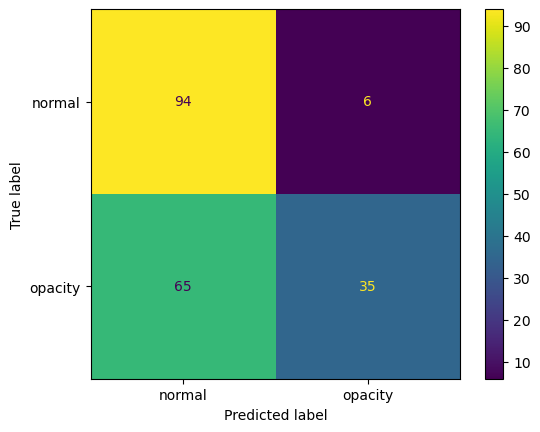

In [ ]:
#summary validation set
y_list = np.array([])
y_hat_list = np.array([])
for X,y in validloader:
  y_hat = mycnn(X.to(device))    
  y_hat = y_hat.argmax(dim=1)
  y_list = np.append(y_list,y)
  y_hat_list = np.append(y_hat_list,y_hat.cpu().numpy())

#ConfusionMatrixDisplay로 표현하기 위해 사이킷런 import
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay
)

print(classification_report(
    y_list,
    y_hat_list,
    target_names=tgtnames))

#summary confusion matrix 
cm = confusion_matrix(
    y_list,
    y_hat_list,
    #normalize='true',
)

#ConfusionMatirxDisplay(confusion_matrx = {confusion_matrix var}, display_labels = {결과 class})
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=tgtnames,
)
disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1])


###valid accuracy 측정 
TT = cm[0][0] + cm[1][1]
valid_prediction = 100 * (TT / 200)
print(f"200명 중 맞춘 확률 : {valid_prediction}%")  


# 3-2. alexnet, vggnet, googlenet, resnet 중 하나의 model를 불러와서 적절히 model을 수정하여 CNN model을 학습

* 학습이 완료된 model을 통해 valid폴더의 데이터(normal 100, opacitiy 100)에 대한 예측을 진행하고 결과를 confusion matrix로 요약합니다.

In [ ]:
#googlenet model setting
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights
resnet_model = resnet50(weights= None)

#fine tuning 
resnet_model.conv1 = torch.nn.Conv2d(1, 64, kernel_size= 7, stride= 2, padding=3) #우리껀 input channel : gray scale(1)
resnet_model.fc = torch.nn.Linear(in_features= 2048, out_features= 2, bias = True) #결과로 정상/비정상을 판단해야하므로 outchannel : 2
print(resnet_model.conv1, resnet_model.fc)

Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3)) Linear(in_features=2048, out_features=2, bias=True)


In [ ]:
#learning
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
resnet_model.to(device)

#Hyper parameter setting 
learning_rate =  .05
num_epochs = 200
# loss func and algo
loss = torch.nn.CrossEntropyLoss() # CE LOSS
alg= torch.optim.SGD(resnet_model.parameters(), lr = learning_rate) #Stochastic Gradient Descent

cpu


In [ ]:
#result check
loss_train = np.array([])
accs_train = np.array([])
accs_valid = np.array([])

#data load
trainset = torchvision.datasets.ImageFolder(root = path_train, transform = train_transforms)
validset = torchvision.datasets.ImageFolder(root = path_valid, transform = train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = train_batch_size, shuffle = True)
validloader = torch.utils.data.DataLoader(validset, batch_size = valid_batch_size, shuffle = False)

for epoch in range(num_epochs):
    i=0
    l_epoch = 0
    correct = 0
    resnet_model.train()
    for X,y in trainloader:
        i=i+1
        X,y = X.to(device),y.to(device)
        y_hat=resnet_model(X)
        correct += (y_hat.argmax(dim=1)==y).sum()
        l=loss(y_hat,y)
        l_epoch+=l
        alg.zero_grad()
        l.backward()
        alg.step()

    loss_train = np.append(loss_train,l_epoch.cpu().detach().numpy()/i)
    accs_train = np.append(accs_train,correct.cpu()/len(trainset))

    correct = 0
    resnet_model.eval()
    for X,y in validloader:
        X,y = X.to(device),y.to(device)
        y_hat = resnet_model(X)
        correct += (y_hat.argmax(dim=1)==y).sum()

    accs_valid = np.append(accs_valid,correct.cpu()/len(validset))

    plt.figure(2,dpi=80)
    plt.subplot(121)
    plt.plot(loss_train,label='train loss')
    plt.legend(loc='upper right')
    plt.subplot(122)
    plt.plot(accs_train,label='train accuracy')
    plt.plot(accs_valid,label='valid accuracy')
    plt.legend(loc='upper left')
    plt.title('epoch: %d '%(epoch))
    plt.savefig('resnet_loss_curve.png')
#    plt.show()
    plt.close(2)

    if epoch%5 == 0:
        print('epoch: %d '%(epoch))
        print('train loss: ',loss_train[-1])
        print('train accuracy: ',accs_train[-1])
        print('valid accuracy: ',accs_valid[-1])
### 너무 ㅇ

epoch: 0 
train loss:  0.0021186063531786203
train accuracy:  1.0
valid accuracy:  0.9950000047683716
epoch: 5 
train loss:  0.0017912429757416248
train accuracy:  1.0
valid accuracy:  1.0
epoch: 10 
train loss:  0.0015644653467461467
train accuracy:  1.0
valid accuracy:  1.0
epoch: 15 
train loss:  0.0013821182074025273
train accuracy:  1.0
valid accuracy:  1.0
epoch: 20 
train loss:  0.0012431301875039935
train accuracy:  1.0
valid accuracy:  1.0
epoch: 25 
train loss:  0.0011302295606583357
train accuracy:  1.0
valid accuracy:  1.0


KeyboardInterrupt: 

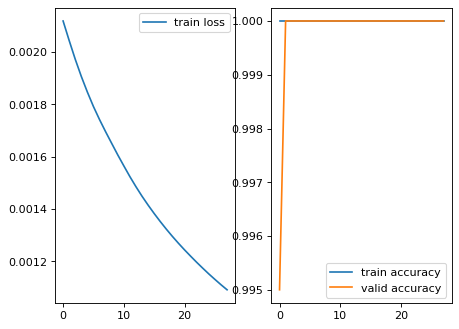

normal
[[ 0.6218316 -0.5332693]]
prediction of mycnn: normal


In [ ]:
from PIL import Image
#result check
plt.figure(2,dpi=80)
plt.subplot(121)
plt.plot(loss_train,label='train loss')
plt.legend(loc='upper right')
plt.subplot(122)
plt.plot(accs_train,label='train accuracy')
plt.plot(accs_valid,label='valid accuracy')
plt.legend(loc='lower right')
plt.show()

N = 42
I = Image.open(validset.imgs[N][0])
X = train_transforms(I)
y = validset.targets[N]

print(tgtnames[y])
y_hat = mycnn(X.unsqueeze(1).to(device))
print(y_hat.cpu().detach().numpy())
y_hat = y_hat.argmax(dim=1)
print(f'prediction of mycnn: {tgtnames[y_hat.cpu().numpy()[0]]}')

              precision    recall  f1-score   support

      normal       1.00      1.00      1.00       100
     opacity       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

200명 중 맞춘 확률 : 100.0%


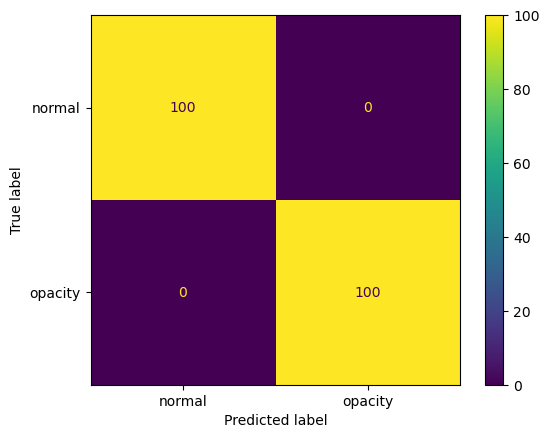

In [ ]:
#summary validation set
y_list = np.array([])
y_hat_list = np.array([])
for X,y in validloader:
  y_hat = resnet_model(X.to(device))    
  y_hat = y_hat.argmax(dim=1)
  y_list = np.append(y_list,y)
  y_hat_list = np.append(y_hat_list,y_hat.cpu().numpy())

#ConfusionMatrixDisplay로 표현하기 위해 사이킷런 import
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay
)

print(classification_report(
    y_list,
    y_hat_list,
    target_names=tgtnames))

#summary confusion matrix 
cm = confusion_matrix(
    y_list,
    y_hat_list,
    #normalize='true',
)

#ConfusionMatirxDisplay(confusion_matrx = {confusion_matrix var}, display_labels = {결과 class})
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=tgtnames,
)
disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1])


###valid accuracy 측정 
TT = cm[0][0] + cm[1][1]
valid_prediction = 100 * (TT / 200)
print(f"200명 중 맞춘 확률 : {valid_prediction}%")  